<a href="https://colab.research.google.com/github/hwarang97/Image_classification/blob/main/VGG16_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
from torch.nn.modules.activation import Softmax
import torch
from torch import nn 
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [98]:
training_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor() # 이미지, 배열을 텐서로 변경하고, 픽셀값을 정규하시켜줌
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor() 
)

train_dataloader = DataLoader(training_data, batch_size=128) # batch_size를 128로 지정하니 정확도가 5퍼대로 나와서 다시 1로 바꿔서 해보는중
test_dataloader = DataLoader(test_data, batch_size=128)

class VGG(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.conv_relu_stack = nn.Sequential(
        nn.Conv2d(1, 6, 5, padding=2), # input 1*28*28, zero_padding=2, output 6*28*28, same padding
        nn.Sigmoid(),
        nn.AvgPool2d(2),
        nn.Conv2d(6, 16, 5),
        nn.Sigmoid(),
        nn.AvgPool2d(2),
    )

    self.linear_relu_stack = nn.Sequential(
      nn.Linear(16*5*5, 84),
      nn.Sigmoid(),
      nn.Linear(84, 10)
    )

  def forward(self, x):
    x1 = self.conv_relu_stack(x)
    x2 = self.flatten(x1)
    logits = self.linear_relu_stack(x2)
    return logits

### 사이즈 오류

- mat1 and mat2 shapes cannot be multiplied (128x400 and 784x84) 

---

- batch_size x flattend pixels, input_pixcels x output_channels

---

- 400과 input_pixcels가 동일해야함

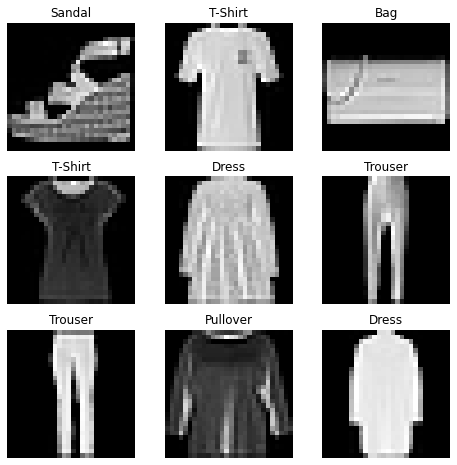

In [32]:
import matplotlib.pyplot as plt

# 데이터셋이 제대로 들어갔는지 시각화해서 확인

labels_map = {
    0: 'T-Shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, rows*cols+1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item() # Tensor에서 값이 하나만 있는 걸 꺼낼때 사용
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis('off') # 축 눈금등을 없애주는 메소드, 기본값:True
  plt.imshow(img.squeeze(), cmap='gray')
plt.show()

In [33]:
# 데이터 갯수 확인
len(training_data), len(test_data)

(60000, 10000)

In [34]:
# dataloader로도 확인할 수 있음
print(train_dataloader.dataset, test_dataloader.dataset)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor() Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [35]:
len(train_dataloader.dataset)

60000

In [36]:
# batch 수를 알아내는 방법 (60000 / 128 = 468.75)
len(train_dataloader)

469

In [101]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset) # train dataset size
  for batch, (X, y) in enumerate(dataloader, 1):

    X = X.to(device)
    y = y.to(device)
    pred = model(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 128 * 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f'loss: {loss:>7f} [{current:>5d}/{size:>5d}]')

def test_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      X = X.to(device)
      y = y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  test_loss /= num_batches
  correct /= size
  print(f'Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n')

In [99]:
model = VGG().to(device)
print(model)

VGG(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv_relu_stack): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=400, out_features=84, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [104]:
learning_rate = 1e-1
epochs = 15

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
  print(f'Epoch {t+1}\n-----------------------------------')
  train_loop(train_dataloader, model, loss_fn, optimizer)
  test_loop(test_dataloader, model, loss_fn)
print('Done!!!')

Epoch 1
-----------------------------------
loss: 2.288726 [16384/60000]
loss: 2.305648 [32768/60000]
loss: 2.306978 [49152/60000]
Test Error: 
 Accuracy: 10.3%, Avg loss: 2.301440 

Epoch 2
-----------------------------------
loss: 2.289125 [16384/60000]
loss: 2.305042 [32768/60000]
loss: 2.305590 [49152/60000]
Test Error: 
 Accuracy: 10.3%, Avg loss: 2.300976 

Epoch 3
-----------------------------------
loss: 2.289261 [16384/60000]
loss: 2.304478 [32768/60000]
loss: 2.304194 [49152/60000]
Test Error: 
 Accuracy: 10.3%, Avg loss: 2.300149 

Epoch 4
-----------------------------------
loss: 2.288776 [16384/60000]
loss: 2.303520 [32768/60000]
loss: 2.302272 [49152/60000]
Test Error: 
 Accuracy: 10.3%, Avg loss: 2.298116 

Epoch 5
-----------------------------------
loss: 2.286195 [16384/60000]
loss: 2.300379 [32768/60000]
loss: 2.296937 [49152/60000]
Test Error: 
 Accuracy: 20.1%, Avg loss: 2.289325 

Epoch 6
-----------------------------------
loss: 2.269079 [16384/60000]
loss: 2.2739

### 배치 사이즈에 따른 학습 성능

- batsize
  - 1 : 10epoch 기준으로 무난히 학습되며 91퍼 기록
  - 128 : 
    - 10epoch, 학습률 0.001 기준으로 학습이 거의 안됨 (5퍼 기록)
    - 30epoch, 학습률 0.001 기준으로도 학습이 거의 안됨 (11퍼 기록)
    - 15epoch, 학습률 0.1 기준으로 성능이 매우 뛰어남 (92.3퍼), 속도도 빠르고 성능도 금방 얻을 수 있었음
---
배치 사이즈가 클수록 일반적인 모델이 되며, 과적합이 일어날 수 있는것같다.

반면, 배치 사이즈가 작으면 불안정하게 수렴하게 되고 불안정한것이 노이즈가 되어 오버피팅되는것을 막는 효과를 줄 수 있다고 한다.

---
배치 사이즈가 큰데, 성능이 잘 안나온다? -> 학습률을 올려라
(참고하는 데이터가 많으니까 특출하게 오차가 많은 것들이 없어저서 조그만한 차이를 크게 볼 수 있어야한듯)

반대로 배치 사이즈가 작으면, 학습률을 낮추면 될듯